In [116]:
import pandas as pd
import dask as dask
from dask import dataframe as dd
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask.array as da
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import seaborn as sns
import ipywidgets as widgets
from clustergrammer2 import net, Network
from clustergrammer_widget import *
import bqplot
from ipywidgets import Layout
from IPython.display import display
import bqplot.pyplot as bqplt
import matplotlib.pyplot as plt

In [117]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='7000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.scale(10)
cluster.adapt(minimum=3, maximum=20)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [ ]:
client = Client(cluster)

In [ ]:
client

In [49]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_flat.sqlite")]
tables = ['aggregates', 'crystals']


In [51]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather


distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 652, in log_errors
    yield
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3134, in replicate
    assert count > 0
AssertionError
distributed.core - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/core.py", line 412, in handle_comm
    result = await result
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/sha

done with submit
done with compute
done with gather
done with submit
CPU times: user 5.74 s, sys: 1.18 s, total: 6.91 s
Wall time: 30.7 s


In [13]:
for item in df.points:
    print(pickle.loads(item))

[( 22.40173739, -15.8843567 , 62.51523222)
 ( 18.37026129,  20.02084359, 91.65281075)
 ( -4.55191249,  58.16183605, 78.4515482 )
 (-23.44261017,  60.39762823, 36.11270711)
 (-19.41113407,  24.49242795,  6.97512858)
 (  3.51103971, -13.64856452, 20.17639113)
 ( 23.19051107, -15.52556816, 62.18224463)
 ( 19.15903497,  20.37963212, 91.31982316)
 ( -3.76313881,  58.52062459, 78.11856061)
 (-22.65383648,  60.75641677, 35.77971952)
 (-18.62236038,  24.85121649,  6.64214099)
 (  4.2998134 , -13.28977598, 19.84340354)]
[(-15.0442687 ,  45.30420704, 42.0417363 )
 ( 12.81579224,  54.83246286,  6.16048722)
 ( 44.57179318,  23.83074534, -7.43674062)
 ( 48.46773319, -16.699228  , 14.84728062)
 ( 20.60767226, -26.22748382, 50.7285297 )
 (-11.14832869,   4.7742337 , 64.32575754)
 (-14.42634808,  45.68265268, 42.62201803)
 ( 13.43371286,  55.2109085 ,  6.74076894)
 ( 45.1897138 ,  24.20919099, -6.8564589 )
 ( 49.08565381, -16.32078235, 15.42756234)
 ( 21.22559288, -25.84903817, 51.30881142)
 (-10.5304

## Memory info and df stats

In [18]:
df[0].memory_usage(deep=True).sum()/1E9
#in GB

0.508032

In [11]:
df[1].info(memory_usage='deep')

<class 'dask.dataframe.core.DataFrame'>
Columns: 4 entries, phi to agg_id
dtypes: object(1), float64(1), int64(2)
memory usage: 314.0 MB


In [21]:
#see partitions
print(df[0].npartitions)
print(df[1].npartitions)

120
120


In [41]:
len(df[0]), len(df[1]) 

(8232439, 8232439)

In [49]:
df_agg = client.persist(df[0]) 

In [50]:
df_mono = client.persist(df[1]) 

In [44]:
agg_stats = df[0]['agg_phi'].describe().round(2).compute()
agg_stats

count    8232439.00
mean           3.98
std            6.74
min            0.01
25%            0.31
50%            2.76
75%           30.08
max           78.33
dtype: float64

In [45]:
r_stats = df[0]['agg_r'].describe().round(2).compute()
r_stats

count    8232439.00
mean        2454.65
std         5282.27
min            0.46
25%          122.19
50%         1349.11
75%        43820.08
max        67900.97
dtype: float64

In [30]:
r_stats = df_crys['r'].describe().round(2).compute()
r_stats

count    7056000.00
mean         158.12
std          290.02
min            1.00
25%            8.25
50%           72.50
75%         1000.00
max         1000.00
dtype: float64

In [32]:
phi_stats = df_crys['phi'].describe().round(2).compute()
phi_stats

count    7056000.00
mean          13.01
std           25.22
min            0.01
25%            0.18
50%            5.46
75%          100.00
max          100.00
dtype: float64

In [195]:
#len(df_crys[df_crys.r == 50])
# frequency count of mono r
count = df[1].r.value_counts() 
# Multi-column frequency count 
count = df_repart.groupby(['agg_phi']).count().compute()
print(count)

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 652, in log_errors
    yield
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3134, in replicate
    assert count > 0
AssertionError
distributed.core - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/core.py", line 412, in handle_comm
    result = await result
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/sha

KeyboardInterrupt: 

## Concat, Repartition, and Clean Up DFs

In [111]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


CPU times: user 15.7 ms, sys: 6.67 ms, total: 22.3 ms
Wall time: 354 ms


In [112]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
len(df_concat) #86% of dataset

7086083

In [113]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

56

In [16]:
res.value_counts()

(19.571, 78.331]                  411622
(12.106, 19.571]                  411622
(0.149, 0.195]                    411622
(0.195, 0.233]                    411622
(0.233, 0.262]                    411622
(0.262, 0.287]                    411622
(0.287, 0.31]                     411622
(0.31, 0.334]                     411622
(0.334, 0.362]                    411622
(0.362, 0.405]                    411622
(0.405, 1.051]                    411622
(1.695, 2.058]                    411622
(2.058, 2.586]                    411622
(2.586, 3.344]                    411622
(3.344, 4.379]                    411622
(4.379, 5.928]                    411622
(5.928, 8.168]                    411622
(8.168, 12.106]                   411622
(0.0057799999999999995, 0.149]    411622
(1.051, 1.695]                    411621
Name: agg_phi, dtype: int64

In [33]:
#df_concat._meta.dtypes
#df_concat.divisions
print(df_concat.npartitions)
print(df_concat.memory_usage(deep=True).sum().compute() / 1024**2)  #5.1 GB

200
5103.192663192749


## Test agg agg queries for collection 

(0, 1000)

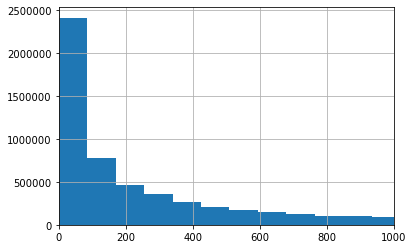

In [149]:
pd_df.agg_r.hist(bins=800)
plt.xlim(0,1000)

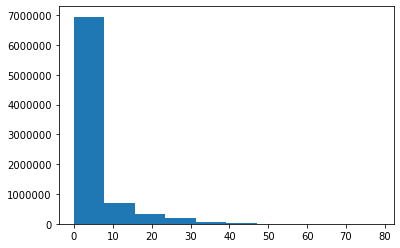

In [193]:
plt.hist(df_repart.agg_phi.compute(), bins =10)
plt.show()

In [114]:
def query_phi(df_repart, phi_lower, phi_upper):
    print('phi', phi_lower, phi_upper)
    df_phi = df_repart[(df_repart.agg_phi > phi_lower) & (df_repart.agg_phi < phi_upper)]
    print(df_phi.head())
    return df_phi


def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for bin in range(len(r_bins)-1):
        print(r_bins[bin], r_bins[bin+1])
        df = df_phi[(df_phi.agg_r > r_bins[bin]) & (df_phi.agg_r < r_bins[bin+1])]
        print('df ncrystals', df.ncrystals)
        avg_ncrystals.append(df.ncrystals.mean())
    print(len(avg_ncrystals),avg_ncrystals)
    return avg_ncrystals


phi 0.006779258140958099 0.1548879241509976
Empty DataFrame
Columns: [ncrystals, agg_phi, agg_r, a, b, c, cplx, phi2D, phi, r, points, agg_id]
Index: []
Empty DataFrame
Columns: [ncrystals, agg_phi, agg_r, a, b, c, cplx, phi2D, phi, r, points, agg_id]
Index: []
2.840717117395828 18.2344893595037
df ncrystals Series([], Name: ncrystals, dtype: int64)
18.2344893595037 32.55301660664517
df ncrystals Series([], Name: ncrystals, dtype: int64)
32.55301660664517 46.28274602166734
df ncrystals Series([], Name: ncrystals, dtype: int64)
46.28274602166734 60.98857397146647
df ncrystals Series([], Name: ncrystals, dtype: int64)
60.98857397146647 76.8784588403677
df ncrystals Series([], Name: ncrystals, dtype: int64)
76.8784588403677 93.63325928381427
df ncrystals Series([], Name: ncrystals, dtype: int64)
93.63325928381427 112.29168408141763
df ncrystals Series([], Name: ncrystals, dtype: int64)
112.29168408141763 134.7377700154026
df ncrystals Series([], Name: ncrystals, dtype: int64)
134.73777001

ValueError: Arrays chunk sizes are unknown: (nan,)

A possible solution: https://docs.dask.org/en/latest/array-chunks.html#unknown-chunks
Summary: to compute chunks sizes, use

   x.compute_chunk_sizes()  # for Dask Array `x`
   ddf.to_dask_array(lengths=True)  # for Dask DataFrame `ddf`

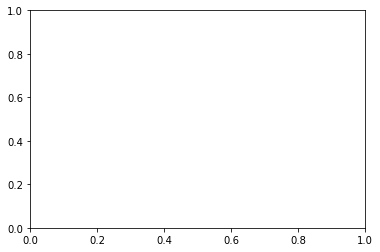

distributed.utils - ERROR - float division by zero
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 652, in log_errors
    yield
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/components/scheduler.py", line 1435, in update
    d = progress_quads(state)
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/diagnostics/progress_stream.py", line 105, in progress_quads
    rl = width * r / a + l
ZeroDivisionError: float division by zero
distributed.utils - ERROR - float division by zero
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 652, in log_errors
    yield
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-package

In [115]:
fig, ax = plt.subplots()
res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
for i in range(len(phi_bins)-1):
    #print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins[i],phi_bins[i+2]))
    
    df_phi = df_repart.map_partitions(query_phi, phi_bins[i], phi_bins[i+1])
    print(df_phi.head())
    res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
    
    #res = pd.cut(res.ncrystals.compute(), bins=r_bins, include_lowest=True)
    avg_ncrystals = df_phi.map_partitions(query_ncrystals, r_bins)
  
    plt.scatter([i]*len(r_bins), avg_ncrystals, marker = "_")

plt.xticks(np.arange(0,len(phi_bin_labs*2),2), phi_bin_labs, rotation=45)
plt.ylabel("Radius Bin Edges",fontsize=16)
plt.xlabel("Aspect Ratio $\phi$",fontsize=16)  
#textstr = '$n$ values per $phi$ :', str(res.value_counts()[0])
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#        vertical alignment='top', bbox=dict(boxstyle='round'))
#17716 values per phi, per r

In [ ]:
res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
for i in range(len(phi_bins)-1):
    #print('i = ', i)
    if i % 2 == 0:
        phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins[i],phi_bins[i+2]))
    df_phi = df_repart.map_partitions(query_phi, phi_bins[i], phi_bins[i+1])
    res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
    plt.scatter([i]*len(r_bins), r_bins, marker = "_")
plt.yscale('log')

plt.xticks(np.arange(0,len(phi_bin_labs*2),2), phi_bin_labs, rotation=45)
plt.ylabel("Radius Bin Edges",fontsize=16)
plt.xlabel("Aspect Ratio $\phi$",fontsize=16)  
#columns tend to aggregate 

CPU times: user 1h 26min 59s, sys: 13min 50s, total: 1h 40min 49s
Wall time: 1h 42min


[(0, 1000)]

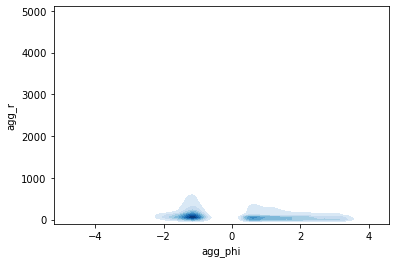

In [111]:
%time sns.kdeplot(np.log(df_repart.agg_phi.compute()), df_repart.agg_r.compute(),cmap="Blues", shade=True, shade_lowest=False)
sns.plt.ylim(0, 1000)

In [ ]:
# Create the pandas DataFrame 
data = [{'0':4, '1': 2, '2':3}, {'0': 10, '1': 20, '2': 30}] 
  
# Creates padas DataFrame by passing  
# Lists of dictionaries and row index. 
df_test = pd.DataFrame(data, index =['first', 'second']) 
net.load_df(df_test)
net.widget()

In [66]:
pd_df = df_repart.drop(['points', 'a', 'b', 'c', 'phi2D', 'cplx', 'agg_id', 'phi', 'r'], axis=1).compute()
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8232439 entries, 1 to 44100
Data columns (total 3 columns):
ncrystals    int64
agg_phi      float64
agg_r        float64
dtypes: float64(2), int64(1)
memory usage: 251.2 MB


In [34]:
x = pd_df.index
y = pd_df.columns


x_sc, y_sc, col_sc = bqplot.OrdinalScale(), bqplot.OrdinalScale(), bqplot.ColorScale(scheme='BuPu')
ax_x = bqplot.Axis(scale=x_sc, label='Years')
ax_y = bqplot.Axis(scale=y_sc, orientation='vertical', label='Months')
ax_c = bqplot.ColorAxis(scale=col_sc)
fig = plt.figure(padding_y=0.0)
grid_map = plt.gridheatmap(pd_df)

#heat = bqplot.GridHeatMap(scales={'row': x_sc, 'column': y_sc, 'color': col_sc}, stroke='white', row=y.tolist(), column=x.tolist())

#fig = bqplot.Figure(marks=[heat], axes=[ax_x, ax_y, ax_c],layout=Layout(width='650px', height='650px'))
fig

Figure(axes=[ColorAxis(scale=ColorScale()), Axis(orientation='vertical', scale=OrdinalScale(reverse=True)), Ax…